## Preparation

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

In [2]:
device=torch.device('cuda:1') #先調1再調0

In [3]:
print(torch.cuda.is_available())

True


In [4]:
x=torch.randn(100).to(device)

C:\Users\ENCHOU\anaconda3\envs\pytorch\lib\site-packages\torch\cuda\__init__.py:120: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


In [5]:
device=torch.device('cuda:0')

## Data

In [6]:
# Step 1. Prepare data-1/2
# DataLoader wraps a Dataset and provides minibatches, shuffling, multithreading, for you
data_in=np.loadtxt('./data/preserved/input_div_U_2_1s.dat')
x_in=torch.Tensor(data_in)
x_in=x_in.to(device)

NameError: name 'data_out' is not defined

In [7]:
x=x_in
print(x.size())

torch.Size([1000, 6400])
torch.Size([1000, 6400])


## Model

In [8]:
# Step 2. Create model 建立model習慣建立class
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, A, B, C, D, E, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear_1=torch.nn.Linear(D_in, A)
        self.linear_2=torch.nn.Linear(A, B)
        self.linear_4=torch.nn.Linear(B, C)
        self.linear_5=torch.nn.Linear(C, D)
        self.linear_6=torch.nn.Linear(D, E)
        self.linear_3=torch.nn.Linear(E, D_out)
    
    # Step 3. Forward pass-1/2    # Step 4. Backward pass-1/2
    def forward(self, x):
        a=self.linear_1(x)
        a_relu=torch.nn.functional.relu(a) #為何activation and hidden layer 的實現方式不同
        b=self.linear_2(a_relu) 
        b_relu=torch.nn.functional.relu(b)
        c=self.linear_4(b_relu) 
        c_relu=torch.nn.functional.relu(c)
        d=self.linear_5(c_relu) 
        d_relu=torch.nn.functional.relu(d)
        e=self.linear_6(d_relu) 
        e_relu=torch.nn.functional.relu(e)
        y_pred=self.linear_3(e_relu) 
        return y_pred
    
model= TwoLayerNet(D_in=6400, A=1000, B=1000, C=1000, D=1000, E=1000, D_out=6400)
model=model.to(device) #這行是什麼意思? A:将模型加载到相应的设备

In [9]:
loader=DataLoader(TensorDataset(x, y), batch_size=100)

## Training

In [13]:
tol=1e-4

In [11]:
optimizer=torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
#optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)

In [14]:
loss_epoch=[]
loss_values = []
loss=1
epochs=0

print("Epochs    Loss")

while(loss>tol):
    epochs=epochs+1
    scheduler.step()
    
    for x_batch, y_batch in loader:
        # Forward pass
        y_pred=model(x_batch)        
        loss=torch.nn.functional.mse_loss(y_pred, x_batch)
        
        # Backward pass
        loss.requires_grad_(True)
        loss.backward()
        
        # Update Weights
        optimizer.step()
        optimizer.zero_grad()
        #print("1 batch")
    
    loss_epoch.append(epochs)
    loss_values.append(loss.item())
    
    if epochs%1==0:
        print("Epochs: ", epochs, "; Loss: ", loss.item())
        
    loss=loss.item()

print(epochs, "    ", loss.item())

#Plot loss function
from matplotlib import pyplot as plt
plt.plot(loss_epoch, loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')

Epochs    Loss


C:\Users\ENCHOU\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epochs:  1 ; Loss:  0.06829725950956345
Epochs:  2 ; Loss:  0.05972548574209213
Epochs:  3 ; Loss:  0.061513327062129974
Epochs:  4 ; Loss:  0.014465313404798508
Epochs:  5 ; Loss:  0.006479773670434952
Epochs:  6 ; Loss:  0.015998098999261856
Epochs:  7 ; Loss:  0.009076292626559734
Epochs:  8 ; Loss:  0.004800233989953995
Epochs:  9 ; Loss:  0.0038139319512993097
Epochs:  10 ; Loss:  0.0016722030704841018


KeyboardInterrupt: 

## Result

[]

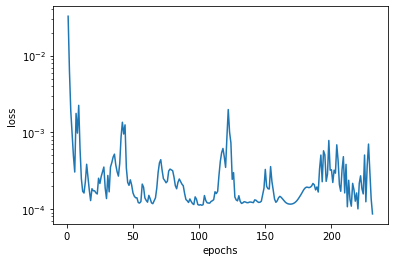

In [14]:
#Plot loss function
from matplotlib import pyplot as plt
plt.plot(loss_epoch, loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.semilogy()

## Export

In [17]:
device=torch.device('cpu')
model=model.to(device)
PATH= "model_jit_uns_cnn_3.pth"
traced_net=torch.jit.trace(model, (torch.randn(1,6400)).to(device))
traced_net.to(torch.float64)
torch.jit.save(traced_net, PATH)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [3, 1, 3, 3], but got 2-dimensional input of size [1, 6400] instead

In [20]:
traced_net=torch.jit.trace(model, (torch.randn(1, 1, 80,80)).to(device))
traced_net.to(torch.float64)
torch.jit.save(traced_net, PATH)